In [1]:
%matplotlib inline
from base import fetch_data, B2B, Forward
from common import log_files, data_path
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import pickle
import time
import submitit
import os.path as op

In [29]:
def run(subject, model_name, overwrite=False):
    """Loop Granger score for each time sample independently"""
    start = time.time()
    print(start)
    
    # Paths
    preproc_path = op.join(data_path, '..', 'jrr', '%s-preproc.pkl' % subject.subject)
    save_path = op.join(data_path, '..', 'jrr', '%s-%s-ts.pkl' % (subject.subject, model_name))
    
    # Don't compute if already exists
    if op.isfile(save_path) and not overwrite:
        with open(save_path, 'rb') as f:
            return pickle.load(f)
    
    # Load and preprocess data
    if op.isfile(preproc_path) and not overwrite:
        with open(preproc_path, 'rb') as f:
            meg, times, features, names = pickle.load(f)
    else:
        meg, times, features, names = fetch_data(subject)
        with open(preproc_path, 'wb') as f:
            pickle.dump([meg, times, features, names], f)

    features = features[:, :12]
    
    # Prepare model
    models = dict(B2B=B2B(knockout=True),
                  Forward=Forward(knockout=True))
    model = models[model_name]
    cv = KFold(5, shuffle=True)
    n_features = features.shape[1]
    _, n_channels, n_times = meg.shape

    # Depending on the model, we may make predictions on different Y dimensions
    window = 10
    n_y = tuple() if model_name == 'B2B' else tuple([n_channels*window, ])

    # Loop across times
    H = np.zeros((cv.n_splits, n_times, n_features, *n_y))
    H_r = np.zeros((cv.n_splits, n_times, n_features, *n_y))
    K_r = np.zeros((cv.n_splits, n_times, n_features, *n_y))

    for t in trange(n_times-window):
        print(t)
        for split, (train, test) in enumerate(cv.split(features)):
            Y = meg[:, :, t:t+window].reshape(len(meg), -1)
            
            # Fit model
            model.fit(X=features[train],
                      Y=Y[train])
            # Retrieve coefficients
            H_ = np.diag(model.H_) if model_name == 'B2B' else model.H_.T
            H[split, t] = H_
            # Compute standard scores
            H_r[split, t] = model.score(X=features[test],
                                        Y=Y[test])
            # Compute knock out scores
            K_r[split, t] = model.score_knockout(X=features[test],
                                                 Y=Y[test])

    # Mean across splits
    H = H.mean(0)
    H_r = H_r.mean(0)
    K_r = K_r.mean(0)
    
    # Save
    print('save')
    with open(save_path, 'wb') as f:
        pickle.dump([H, H_r, K_r], f)
    
    
    print(time.time() - start)
    
    return H, H_r, K_r

In [30]:
preproc_path = op.join(data_path, '..', 'jrr',
                       '%s-preproc.pkl' % log_files.iloc[0].subject)

with open(preproc_path, 'rb') as f:
    _, times, features, names = pickle.load(f)

In [31]:
log_path = op.join(data_path, '..', 'jrr', 'log')
executor = submitit.AutoExecutor(folder=log_path)
executor.update_parameters(timeout_min=20, partition='dev',
                           constraint='pascal', cpus_per_task=12)

In [40]:
executor = submitit.LocalExecutor('./tmp/')

In [7]:
log_files = log_files.query('task=="visual"')

In [51]:
jobs = list()
for subject in trange(3): # len(log_files)):
    subject_info = log_files.iloc[subject]
    save_path = op.join(data_path, '..', 'jrr', 
                        '%s-%s-ts.pkl' % (subject_info.subject, model_name))
    if op.isfile(save_path):
        continue
    jobs.append(executor.submit(run, subject_info, 'B2B', False))

100%|██████████| 3/3 [00:00<00:00,  9.85it/s]


In [56]:
result = jobs[0]

In [50]:
jobs[0].stderr()

'Traceback (most recent call last):\n  File "/private/home/jeanremi/.conda/envs/mous/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)\n  File "/private/home/jeanremi/.conda/envs/mous/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)\n  File "/private/home/jeanremi/.conda/envs/mous/lib/python3.6/site-packages/submitit/_submit.py", line 6, in <module>\n    submitit_main()\n  File "/private/home/jeanremi/.conda/envs/mous/lib/python3.6/site-packages/submitit/submission.py", line 169, in submitit_main\n    process_job(args.folder)\n  File "/private/home/jeanremi/.conda/envs/mous/lib/python3.6/site-packages/submitit/submission.py", line 162, in process_job\n    raise error\n  File "/private/home/jeanremi/.conda/envs/mous/lib/python3.6/site-packages/submitit/submission.py", line 153, in process_job\n    result = delayed.result()\n  File "/private/home/jeanremi/.conda/envs/mous/lib/python3.6/site-packages/submitit/utils.py", line 11

In [39]:
job = jobs[0]
job.stderr()

'Traceback (most recent call last):\n  File "/private/home/jeanremi/.conda/envs/mous/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)\n  File "/private/home/jeanremi/.conda/envs/mous/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)\n  File "/private/home/jeanremi/.conda/envs/mous/lib/python3.6/site-packages/submitit/_submit.py", line 6, in <module>\n    submitit_main()\n  File "/private/home/jeanremi/.conda/envs/mous/lib/python3.6/site-packages/submitit/submission.py", line 169, in submitit_main\n    process_job(args.folder)\n  File "/private/home/jeanremi/.conda/envs/mous/lib/python3.6/site-packages/submitit/submission.py", line 162, in process_job\n    raise error\n  File "/private/home/jeanremi/.conda/envs/mous/lib/python3.6/site-packages/submitit/submission.py", line 153, in process_job\n    result = delayed.result()\n  File "/private/home/jeanremi/.conda/envs/mous/lib/python3.6/site-packages/submitit/utils.py", line 11

In [38]:
for job in jobs:
    job.cancel()

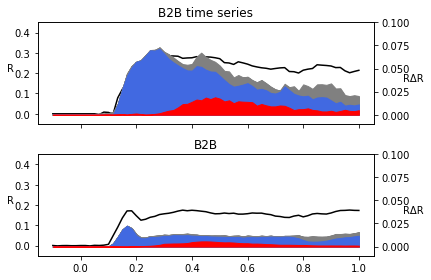

In [84]:
def get_results(model_name):
    
    H, H_r, K_r = list(), list(), list()
    for subject in range(len(log_files)):
        subject = log_files.loc[subject, 'subject']
        save_path = op.join(data_path, '..', 'jrr', 
                            '%s-%s%s.pkl' % (subject, 'B2B', model_name))
        if op.isfile(save_path):
            with open(save_path, 'rb') as f:
                dat = pickle.load(f)
            H.append(dat[0]) 
            H_r.append(dat[1])
            K_r.append(dat[2])

    H, H_r, K_r = np.nanmean(H, 0), np.nanmean(H_r, 0), np.nanmean(K_r, 0)
    return H, H_r, K_r


def plot(scores, H_r, ax_right=None):
    ax_right = plt.gca() if ax_right is None else ax_right
    ax_left = ax_right.twinx()
    ax_left.plot([0,0],[0,0], color='k') # for legend
    s = np.zeros(len(times))
    for idx, r in enumerate(scores.T):
        if idx == 0:
            color = 'red'
        elif idx == 1:
            color = 'royalblue'
        else:
            color = 'gray'
        s += r
        ax_left.fill_between(times, s, zorder=-idx,
                              color=color)
    ax_left.set_ylim(-.01, .1)
    ax_left.set_ylabel('RΔR').set_rotation(0)
    ax_right.plot(times, H_r, color='k')
    ax_right.set_ylabel('R').set_rotation(0)
    ax_right.set_ylim(-.05, .45)

    return ax_left, ax_right

fig, axes = plt.subplots(2, 1,
                         sharex=True, sharey=True)

H, H_r, K_r = get_results('')
scores = H_r * (H_r - K_r)
ax_left, ax_right = plot(scores, H_r.mean(1), axes[1])
axes[1].set_title('B2B')

H, H_r, K_r = get_results('-ts')
scores = H_r * (H_r - K_r)
scores = np.roll(scores, 10, axis=0)
H_r = np.roll(H_r, 10, axis=0)

ax_left, ax_right = plot(scores, H_r.mean(1), axes[0])
axes[0].set_title('B2B time series')
fig.tight_layout()

In [71]:
H_r.shape

(67, 12)

In [67]:
scores.shape

(67, 12)

In [60]:
scores.shape

(67, 12)

In [ ]:
result = 

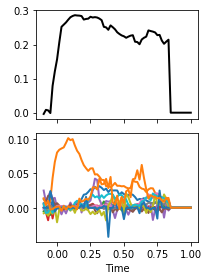

In [28]:
fig, axes = plt.subplots(2, 1, figsize=[3, 4], sharex=True)
H, H_r, K_r = result #get_results('B2B')
# H_r = H_r[:, [1, 0]]
# K_r = K_r[:, [1, 0]]
scores = H_r - K_r
#for s, c in zip(scores.T, ('royalblue', 'red')):
r = 0*scores[:, 0]
for s in scores.T:
    r+=s
    axes[1].plot(times, s, lw=2)
axes[0].plot(times, np.mean(H_r, 1), color='k', lw=2)

plt.xlabel('Time')
#plt.xlim(0,  1.)
plt.tight_layout()

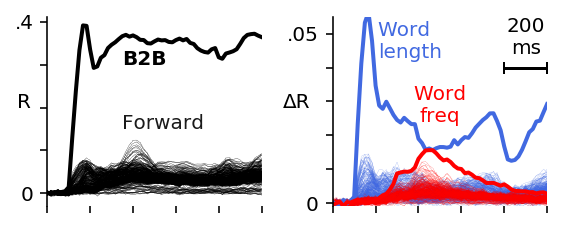

In [197]:
fig, axes = plt.subplots(1, 2, figsize=[4, 1.7], sharex=True)
# Legend
lines = [
    plt.plot([0], [0], color='k', lw=2)[0],
    plt.plot([0], [0], color='k', linestyle=':', lw=.5)[0],
    plt.plot([0], [0], color='red')[0], 
    plt.plot([0], [0], color='royalblue')[0],   
]

H, H_r, K_r = get_results('Forward')
H_r = H_r[:, [1, 0]]
K_r = K_r[:, [1, 0]]
scores = H_r - K_r
for s, c in zip(scores.transpose(1,0,2), ('royalblue', 'red')):
    axes[1].plot(times, s, color=c, linestyle=':', lw=.2)
for s in H_r.transpose(1,0,2):
    axes[0].plot(times, s, color='k', linestyle=':', lw=.2)

H, H_r, K_r = get_results('B2B')
H_r = H_r[:, [1, 0]]
K_r = K_r[:, [1, 0]]
scores = H_r - K_r
for s, c in zip(scores.T, ('royalblue', 'red')):
    axes[1].plot(times, s, color=c, lw=2)
axes[0].plot(times, np.mean(H_r, 1), color='k', lw=2)

axes[0].set_ylabel('R', labelpad=-5).set_rotation(0)
axes[1].set_ylabel('ΔR', labelpad=-5).set_rotation(0)
axes[1].set_xlim(times[0], times[-1])
for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
# plt.figlegend(lines, ('B2B', 'Forward', 'word frequency', 'word length'),
#               columnspacing=1, handlelength=.8, handletextpad=.2,
#               loc='upper center', ncol=4,
#               bbox_to_anchor=(.5, 1.1))
axes[0].set_yticks([0, .1, .2, .3, .4])
axes[0].set_yticklabels(['0', '', '', '', '.4'])
axes[1].set_yticks([0, .01, .02, .03, .04, .05])
axes[1].set_ylim(-.001, 0.055)
axes[1].set_yticklabels(['0', '', '', '', '', '.05'])
#axes[0].set_xlabel('Time (ms)')
#axes[1].set_xlabel('Time (ms)')

axes[0].text(.35, .3, 'B2B', color='k', weight='bold')
axes[0].text(.35, .15, 'Forward', color=[.1, .1, .1])

axes[1].text(.5, .024, 'Word\nfreq', color='red', horizontalalignment='center')
axes[1].text(.21, .043, 'Word\nlength', color='royalblue', horizontalalignment='left')

axes[1].plot([.8, 1.], [.04, .04], color='k', marker='|')
axes[1].text(.9, .044, '200\nms', color='k', horizontalalignment='center')

plt.xlim(0,  1.)
axes[0].set_xticks(np.arange(0, 1.001, .2))
axes[0].set_xticklabels([])#['0', '', '', '', '', '500','', '', '', '', '1000'])
plt.tight_layout()

In [200]:
%retina

UsageError: Line magic function `%retina` not found.


In [201]:
fig.savefig('rebuttal.pdf')

In [ ]:
plt.legend()

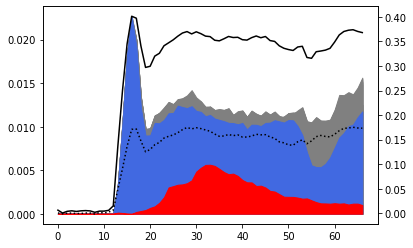

In [115]:
scores = H_r * (H_r - K_r)
colors = ['red', 'blue']
colors += plt.get_cmap('Reds')(np.linspace(0., 1., 10)).tolist()
colors += plt.get_cmap('Blues')(np.linspace(0., 1., 26)).tolist()
order = np.argsort(np.nan_to_num(np.nanmean(scores, 0)))[::-1]
order = np.argsort(np.argmax(scores, 0))
s = np.zeros(len(times))
for idx, r in enumerate(scores.T):
    s += r
    if idx == 0:
        color = 'red'
    elif idx == 1:
        color = 'royalblue'
    else:
        color = 'gray'
    plt.fill_between(times, s, zorder=-idx,
                     color=color)
ax_right = plt.gca().twinx()
#ax_right.plot(times, H_r)
ax_right.plot(times, np.max(H_r, 1), color='k')